In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import skew
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os
os.chdir('/Users/liyuan/desktop/SI699/codes')

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn import tree

In [2]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [4]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

class modeling_pipeline():
    def __init__(self,data,model,variables):
        self.data = data.iloc[:]
        self.train_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.model = model
        self.variables = variables
        self.X_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.X_val = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.y_val = pd.DataFrame()

        self.categorical_vars = ['srch_id','site_id','visitor_location_country_id','visitor_hist_starrating','prop_country_id','prop_id',
        'srch_destination_id']

        self.categorical_binary_vars = []
        self.continuous_vars = []

        self.X_train_normalized = pd.DataFrame()
        self.X_val_normalized = pd.DataFrame()
        self.X_test_normalized = pd.DataFrame()

        self.X_train_standardized = pd.DataFrame()
        self.X_val_standardized = pd.DataFrame()
        self.X_test_standardized = pd.DataFrame()
 
    def split_data(self):
        training_size_large = int(len(self.data) * 0.8)   
        validation_size = int(training_size_large * 0.2)
        training_size = training_size_large - validation_size
        test_size = int(len(self.data) * 0.2)
        print('training size: %d'%training_size)
        print('validation size: %d'%validation_size)
        print('test size: %d'%test_size)
        # split data by temporal order
        self.train_data = self.data.iloc[0: training_size]
        self.val_data = self.data.iloc[training_size:(training_size + validation_size)]
        # self.test_data = self.data.iloc[(training_size + validation_size): (training_size + validation_size + test_size)]
        self.test_data = self.data.iloc[(training_size + validation_size):]
        return self.train_data, self.val_data, self.test_data
    
    def divide_variables(self):
        # divide variables into categories
        # get categorical variables
        other_cols = [col for col in self.variables if col not in self.categorical_vars]
        # get categorical binary variables
        self.categorical_binary_vars += ['promotion_flag']
        self.categorical_binary_vars += [col for col in self.data if col.startswith('new')]
        self.categorical_binary_vars += [col for col in self.data if col.endswith('inv')]
        self.categorical_binary_vars += [col for col in self.data if col.endswith('bool')]
        # get continous variables
        self.continuous_vars += [ col for col in self.variables if (col not in self.categorical_binary_vars) & (col not in self.categorical_vars )]
        print ("categorical binary vars: ", len(self.categorical_binary_vars))
        print ("categorical non binary vars: ", len(self.categorical_vars))
        print ("continues vars: ", len(self.continuous_vars))
        return self.categorical_vars, self.categorical_binary_vars, self.continuous_vars

    def get_X_y(self):
        # TODO: need to handle 'date_time' properly
        # for now, leave out "date_time" from modeling
        # self.variables += [col for col in self.data.columns.unique().tolist() if col not in ['price_usd','date_time']]
        self.X_train = self.train_data[self.variables]
        self.y_train = self.train_data['price_usd']
        self.X_val = self.val_data[self.variables]
        self.y_val = self.val_data['price_usd']
        self.X_test = self.test_data[self.variables]
        self.y_test = self.test_data['price_usd']
        return self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test

    def get_normalized_X_y(self):
        normalizer = Normalizer().fit(self.X_train) 
        self.X_train_normalized = normalizer.transform(self.X_train)
        self.X_val_normalized = normalizer.transform(self.X_val)
        self.X_test_normalized = normalizer.transform(self.X_test)
        return self.X_train_normalized, self.X_val_normalized, self.X_test_normalized
    
    def get_standardized_X_y(self):
        # usign min-max scaler to standardized
        scaler = MinMaxScaler().fit(self.X_train)
        self.X_train_standardized = scaler.transform(self.X_train)
        self.X_val_standardized = scaler.transform(self.X_val)
        return self.X_train_standardized, self.X_val_standardized, self.X_test_standardized 

    def get_RMSE(self,y_pred,y_true,data):
        return np.sqrt(sum((y_pred - y_true)**2)/len(data))
    
    # updated: adding y_pred_test and test_RMSE
    def get_modeling_result(self):
        reg = self.model.fit(self.X_train, self.y_train)
        y_pred_val = reg.predict(self.X_val)
        y_pred_train = reg.predict(self.X_train)
        y_pred_test = reg.predict(self.X_test)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        test_RMSE = self.get_RMSE(y_pred_test ,self.y_test, self.test_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        print('test RMSE:',test_RMSE)
        return y_pred_train, y_pred_val, y_pred_test

    def get_normalized_modeling_result(self):
        reg = self.model.fit(self.X_train_normalized, self.y_train)
        y_pred_val = reg.predict(self.X_val_normalized)
        y_pred_train = reg.predict(self.X_train_normalized)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        return train_RMSE, val_RMSE

    def get_standardized_modeling_result(self):
        reg = self.model.fit(self.X_train_standardized, self.y_train)
        y_pred_val = reg.predict(self.X_val_standardized)
        y_pred_train = reg.predict(self.X_train_standardized)
        val_RMSE = self.get_RMSE(y_pred_val, self.y_val, self.val_data)
        train_RMSE = self.get_RMSE(y_pred_train ,self.y_train, self.train_data)
        print('training RMSE:',train_RMSE)
        print('valiation RMSE:',val_RMSE)
        return train_RMSE, val_RMSE

In [6]:
def split_data():
    training_size_large = int(len(self.data) * 0.8)
    validation_size = int(training_size_large * 0.2)
    training_size = training_size_large - validation_size
    test_size = int(len(self.data) * 0.2)
    print('training size: %d'%training_size)
    print('validation size: %d'%validation_size)
    print('test size: %d'%test_size)
    # split data by temporal order
    self.train_data = self.data.iloc[0: training_size]
    self.val_data = self.data.iloc[training_size:(training_size + validation_size)]
    self.test_data = self.data.iloc[(training_size + validation_size): (training_size + validation_size + test_size)]
    return self.train_data, self.val_data, self.test_data

In [7]:
train = pd.read_csv('../expedia_data/train.csv')
test = pd.read_csv('../expedia_data/test.csv')
cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
train = train.drop(columns = cols_train_only)
all_data = pd.concat([train, test], ignore_index=True)

In [9]:
comp_features = ['comp1_rate','comp1_inv','comp1_rate_percent_diff','comp2_inv','comp2_rate','comp2_rate_percent_diff','comp3_rate','comp3_inv','comp3_rate_percent_diff','comp4_rate','comp4_inv','comp4_rate_percent_diff','comp5_rate','comp5_inv','comp5_rate_percent_diff','comp6_rate','comp6_inv','comp6_rate_percent_diff','comp7_rate','comp7_inv','comp7_rate_percent_diff','comp8_rate','comp8_inv','comp8_rate_percent_diff']

In [10]:
user_features = ['visitor_hist_starrating','visitor_hist_adr_usd','srch_query_affinity_score','orig_destination_distance','site_id','visitor_location_country_id','srch_id']
other_features = ['random_bool']
time_features = ['date_time']

In [11]:
all_data.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv

In [12]:
all_data = all_data.drop(columns = comp_features)

In [13]:
all_data = all_data.drop(columns = user_features)

In [14]:
all_data = all_data.drop(columns = other_features)

In [15]:
all_data.columns

Index(['date_time', 'prop_country_id', 'prop_id', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'price_usd',
       'promotion_flag', 'srch_destination_id', 'srch_length_of_stay',
       'srch_booking_window', 'srch_adults_count', 'srch_children_count',
       'srch_room_count', 'srch_saturday_night_bool'],
      dtype='object')

In [15]:
all_data['date_time'] = pd.to_datetime(all_data.date_time)
all_data.sort_values(by=['date_time'],inplace=True)
all_data = all_data.reset_index(drop=True)

In [16]:
all_data.head()

,date_time,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool
0,2012-11-01 00:01:37,225,24202,3,0.0,0,4.73,0.3831,4.97,93.07,1,14083,2,16,1,0,1,1
1,2012-11-01 00:01:37,225,327,4,4.5,0,3.66,0.1358,5.31,142.71,0,14083,2,16,1,0,1,1
2,2012-11-01 00:01:37,225,20797,3,3.0,0,4.65,0.1955,4.97,79.22,0,14083,2,16,1,0,1,1
3,2012-11-01 00:01:37,225,53733,3,3.0,0,4.49,0.1079,4.97,74.20,0,14083,2,16,1,0,1,1
4,2012-11-01 00:01:37,225,57269,4,4.5,0,4.62,0.1302,5.26,433.39,1,14083,2,16,1,0,1,1


In [17]:
country_counts = all_data['prop_country_id'].value_counts()

In [18]:
d = {}

for ID in country_counts.index:
    d[ID] = country_counts[ID]

In [19]:
country_id = all_data['prop_country_id'].tolist()

In [20]:
country_pop = []
for ID in country_id:
    country_pop.append(d[ID])

In [21]:
all_data['country_value_counts'] = country_pop

In [22]:
city_counts = all_data['srch_destination_id'].value_counts()

In [23]:
city = {}
for ID in city_counts.index:
    city[ID] = city_counts[ID]
city_id = all_data['srch_destination_id'].tolist()

In [24]:
city_pop = []
for ID in city_id:
    city_pop.append(city[ID])

In [25]:
all_data['city_value_counts'] = city_pop

In [26]:
all_data_new = all_data.drop(columns = 'prop_country_id')
all_data_new = all_data_new.drop(columns = 'srch_destination_id')

In [27]:
all_data_new.head()

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,country_value_counts,city_value_counts
0,2012-11-01 00:01:37,24202,3,0.0,0,4.73,0.3831,4.97,93.07,1,2,16,1,0,1,1,44358,2512
1,2012-11-01 00:01:37,327,4,4.5,0,3.66,0.1358,5.31,142.71,0,2,16,1,0,1,1,44358,2512
2,2012-11-01 00:01:37,20797,3,3.0,0,4.65,0.1955,4.97,79.22,0,2,16,1,0,1,1,44358,2512
3,2012-11-01 00:01:37,53733,3,3.0,0,4.49,0.1079,4.97,74.20,0,2,16,1,0,1,1,44358,2512
4,2012-11-01 00:01:37,57269,4,4.5,0,4.62,0.1302,5.26,433.39,1,2,16,1,0,1,1,44358,2512


In [28]:
prop_116942 = all_data_new[all_data_new['prop_id']==116942]

In [29]:
prop_116942.head()

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,country_value_counts,city_value_counts
1735,2012-11-01 02:14:22,116942,4,4.0,0,4.06,0.2108,5.31,52.00,1,2,27,8,0,4,0,10087872,234506
2290,2012-11-01 03:06:43,116942,4,4.0,0,4.06,0.2108,5.31,90.00,1,3,16,2,0,1,1,10087872,234506
2845,2012-11-01 04:09:50,116942,4,4.0,0,4.06,0.2108,5.31,58.00,1,1,33,1,0,1,0,10087872,234506
7444,2012-11-01 07:47:45,116942,4,4.0,0,4.06,0.2108,5.31,55.19,1,5,45,2,0,1,0,10087872,234506
10648,2012-11-01 08:59:57,116942,4,4.0,0,4.06,0.2108,5.31,132.00,1,3,7,2,2,1,1,10087872,234506


In [30]:
all_data_t = prop_116942.set_index('date_time')
prop_116942_day = all_data_t.resample('D').median()

In [31]:
prop_116942_day.count()

prop_id                      242
prop_starrating              242
prop_review_score            242
prop_brand_bool              242
prop_location_score1         242
prop_location_score2         242
prop_log_historical_price    242
price_usd                    242
promotion_flag               242
srch_length_of_stay          242
srch_booking_window          242
srch_adults_count            242
srch_children_count          242
srch_room_count              242
srch_saturday_night_bool     242
country_value_counts         242
city_value_counts            242
dtype: int64

In [32]:
draw_missing_data_table(prop_116942_day)

,Total,Percent
city_value_counts,0,0.0
price_usd,0,0.0
prop_starrating,0,0.0
prop_review_score,0,0.0
prop_brand_bool,0,0.0
prop_location_score1,0,0.0
prop_location_score2,0,0.0
prop_log_historical_price,0,0.0
promotion_flag,0,0.0
country_value_counts,0,0.0


In [33]:
def split_data(data):
    training_size_large = int(len(data) * 0.8)
    validation_size = int(training_size_large * 0.2)
    training_size = training_size_large - validation_size
    test_size = int(len(data) * 0.2)
    print('training size: %d'%training_size)
    print('validation size: %d'%validation_size)
    print('test size: %d'%test_size)
    # split data by temporal order
    train_data = data.iloc[0: training_size]
    val_data = data.iloc[training_size:(training_size + validation_size)]
    # self.test_data = self.data.iloc[(training_size + validation_size): (training_size + validation_size + test_size)]
    test_data = data.iloc[(training_size + validation_size):]
    return train_data, val_data, test_data

In [34]:
prop_116942_day = prop_116942_day.drop(columns = 'prop_id')
prop_116942_day.describe()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,country_value_counts,city_value_counts
count,242.0,242.0,242.0,2.420000e+02,2.420000e+02,242.000000,242.000000,242.000000,242.000000,242.000000,242.0,242.0,242.0,242.000000,242.0,242.0
mean,4.0,4.0,0.0,4.060000e+00,2.108000e-01,4.667231,106.002851,0.987603,2.305785,31.154959,2.0,0.0,1.0,0.349174,10087872.0,234506.0
std,0.0,0.0,0.0,2.492054e-14,5.562620e-16,1.691754,18.939997,0.110877,0.450320,12.381210,0.0,0.0,0.0,0.465600,0.0,0.0
min,4.0,4.0,0.0,4.060000e+00,2.108000e-01,0.000000,64.500000,0.000000,2.000000,5.000000,2.0,0.0,1.0,0.000000,10087872.0,234506.0
25%,4.0,4.0,0.0,4.060000e+00,2.108000e-01,5.270000,92.500000,1.000000,2.000000,24.000000,2.0,0.0,1.0,0.000000,10087872.0,234506.0
50%,4.0,4.0,0.0,4.060000e+00,2.108000e-01,5.270000,104.597500,1.000000,2.000000,30.000000,2.0,0.0,1.0,0.000000,10087872.0,234506.0
75%,4.0,4.0,0.0,4.060000e+00,2.108000e-01,5.280000,120.000000,1.000000,3.000000,39.000000,2.0,0.0,1.0,1.000000,10087872.0,234506.0
max,4.0,4.0,0.0,4.060000e+00,2.108000e-01,5.310000,170.000000,1.000000,3.000000,82.000000,2.0,0.0,1.0,1.000000,10087872.0,234506.0


In [35]:
X = prop_116942_day[prop_116942_day.loc[:,prop_116942_day.columns != 'price_usd'].columns]
y = prop_116942_day['price_usd']
X_train_data, X_val_data, X_test_data = split_data(X)
y_train_data, y_val_data, y_test_data = split_data(y)

training size: 155
validation size: 38
test size: 48
training size: 155
validation size: 38
test size: 48


In [36]:
lr = LinearRegression()
lr.fit(X_train_data, y_train_data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
scores = cross_val_score(lr, X_train_data, y_train_data, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: -0.697 +/- 1.153


<module 'matplotlib.pyplot' from '/anaconda3/envs/leetcode/lib/python3.6/site-packages/matplotlib/pyplot.py'>

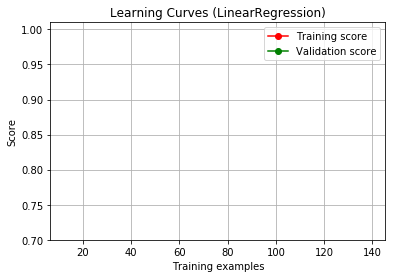

In [38]:
title = "Learning Curves (LinearRegression)"
cv = 10
plot_learning_curve(lr, title, X_train_data, y_train_data, ylim = (0.7, 1.01), cv = cv, n_jobs = 1)

In [39]:
variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd']]
model_prop_lr = modeling_pipeline(prop_116942_day, LinearRegression(), variables)
train_data, val_data, test_data = model_prop_lr.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_lr.get_X_y()
model_prop_lr.get_modeling_result()

training size: 155
validation size: 38
test size: 48
training RMSE: 16.099507907716564
valiation RMSE: 19.35634870985138
test RMSE: 2408.3134078964786


(array([ 98.05951169,  81.94616234,  88.38656248,  91.63018273,
         88.00466975,  88.03234773,  88.03788332,  87.87735106,
         97.70529693, 100.87567665,  94.34542918, 104.10141232,
         97.56690705,  87.98529517,  87.97699177,  88.08216808,
         87.96592058,  88.00190195, 135.03557934,  93.98014323,
         93.99121442, 103.66416363,  94.01335681,  94.00228561,
         93.99675002,  94.00782121, 100.42331118, 110.09902818,
         94.03273139,  93.99121442,  94.024428  ,  94.00782121,
        106.50949657, 100.06079303, 106.48181859, 100.05248963,
        100.08293541, 100.06079303, 100.0912388 , 100.0940066 ,
        100.05525743, 129.86426456, 129.92515611, 106.52887115,
        106.48458639, 100.13275577,  94.05764157, 100.5146485 ,
        103.76657214, 100.50357731,  94.11299752,  94.12406871,
         94.1351399 , 104.98306936, 100.13275577, 109.82784735,
        100.14382696, 116.24610512, 100.04418624, 100.12168458,
        106.14421062, 116.08003726, 106.

In [40]:
variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd']]
model_prop_Rg = modeling_pipeline(prop_116942_day, Ridge(), variables)
train_data, val_data, test_data = model_prop_Rg.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_Rg.get_X_y()
model_prop_Rg.get_modeling_result()

training size: 155
validation size: 38
test size: 48
training RMSE: 17.212582082880914
valiation RMSE: 18.80548065819218
test RMSE: 41.93943469024399


(array([117.03566535,  98.97327287, 105.2869494 , 110.50437472,
         98.52340918,  97.97937393,  97.87056688, 101.02597129,
        109.72808988, 113.86419158, 106.79561258, 116.91222279,
        112.44826609,  98.90423385,  99.06744442,  97.00011049,
         99.28505852,  98.5778127 , 133.93708132,  99.70565121,
         99.48803711, 111.23675305,  99.05280891,  99.27042301,
         99.37923006,  99.16161596, 105.96492421, 117.65923663,
         98.67198424,  99.48803711,  98.83519482,  99.16161596,
        104.97102527,  98.82055931, 105.51506051,  98.98376989,
         98.38533112,  98.82055931,  98.22212055,  98.16771702,
         98.92936636, 120.37432321, 119.17744567, 104.5902006 ,
        105.46065699,  97.40606768,  98.18235253, 104.16960791,
        109.22382265, 104.38722201,  97.09428204,  96.87666794,
         96.65905385, 103.00840803,  97.40606768, 108.71955543,
         97.18845358, 115.46846016,  99.14698046,  97.62368178,
         97.8810639 , 118.73267161, 106.

In [41]:
variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd']]
model_prop_d = modeling_pipeline(prop_116942_day, tree.DecisionTreeRegressor(), variables)
train_data, val_data, test_data = model_prop_d.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_d.get_X_y()
model_prop_d.get_modeling_result()

training size: 155
validation size: 38
test size: 48
training RMSE: 2.941157674750188
valiation RMSE: 24.811735763121195
test RMSE: 22.974050789834113


(array([105.    , 105.    , 127.14  ,  91.38  ,  91.605 ,  66.785 ,
         97.    , 114.    , 100.5   , 106.595 ,  83.    ,  97.    ,
         96.5   ,  75.5   ,  82.    ,  76.    ,  84.9   ,  71.5   ,
        131.    , 104.    ,  77.5   ,  80.    ,  75.    ,  78.    ,
         64.5   , 110.    ,  81.5   ,  94.    ,  65.055 ,  77.5   ,
         67.    , 110.    ,  90.    ,  82.5   , 107.98  , 102.    ,
         97.    ,  82.5   ,  88.5   ,  96.    , 127.435 , 143.825 ,
        120.    , 150.    , 120.46  ,  94.985 ,  88.64  ,  85.    ,
        130.255 , 100.23  ,  91.325 ,  80.    ,  81.    , 100.    ,
         94.985 , 129.    , 133.    , 142.43  , 132.4   ,  95.    ,
         95.    , 112.    , 117.    , 101.68  ,  99.685 , 100.09  ,
        118.245 , 125.71  , 125.    , 100.    , 100.    ,  99.51  ,
         95.175 , 103.26  , 102.5   , 125.    , 100.    ,  97.175 ,
        100.    ,  95.605 ,  92.    , 116.6975, 110.    ,  92.    ,
         94.57  ,  94.57  , 120.    ,  99.    , 

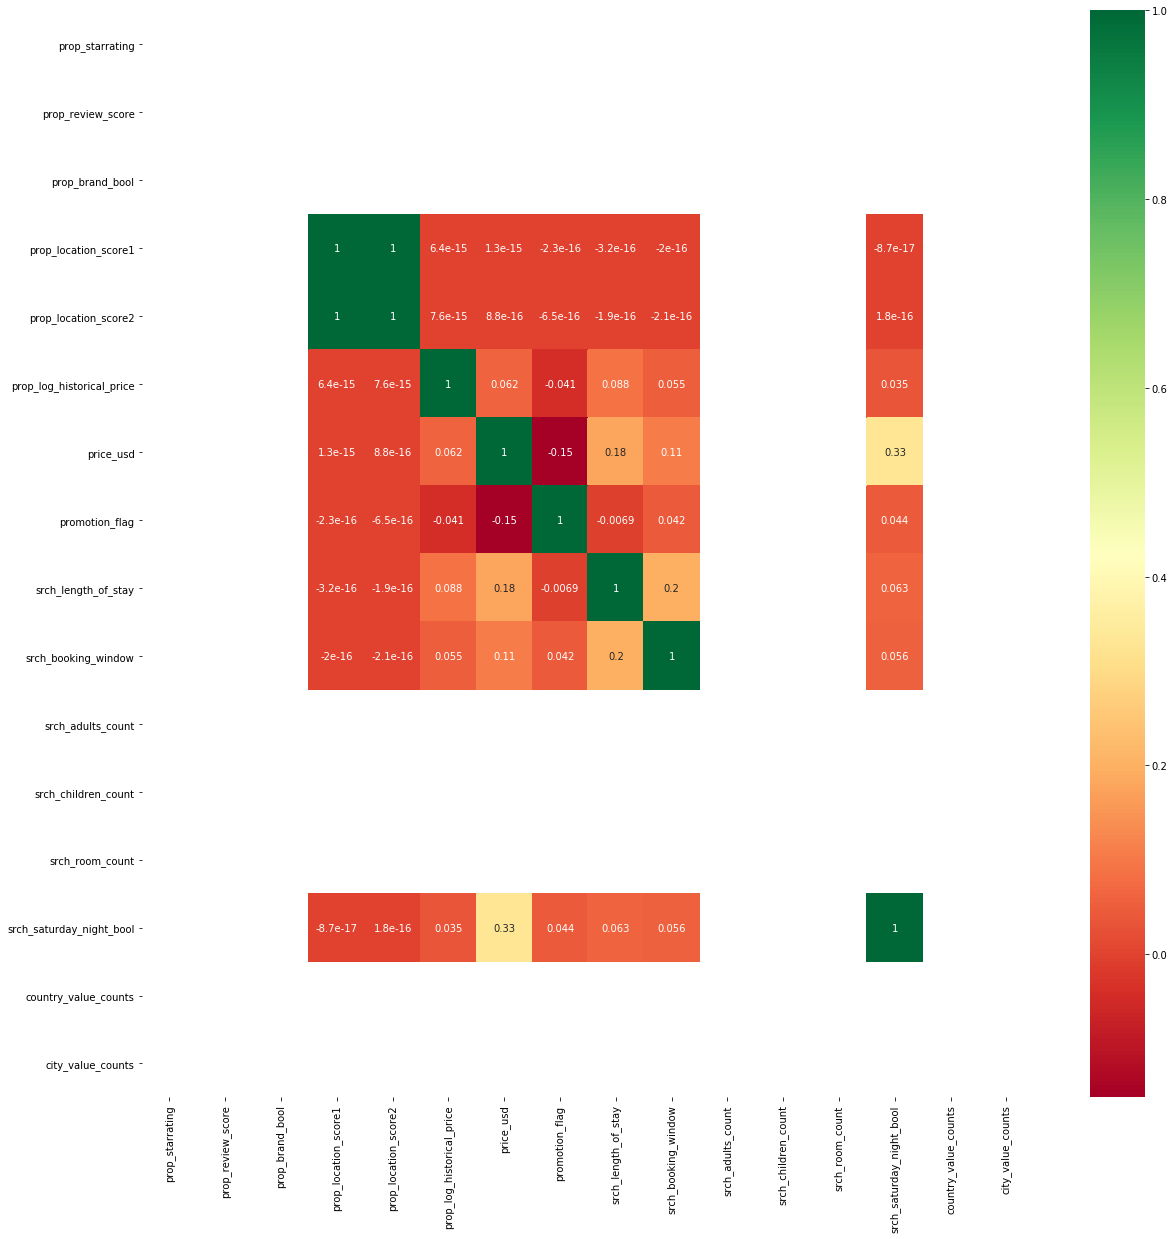

In [42]:
X = prop_116942_day[prop_116942_day.loc[:, prop_116942_day.columns != 'price_usd'].columns]  #independent columns
y = prop_116942_day['price_usd']    #target column i.e price range

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns

#get correlations of each features in dataset
corrmat = prop_116942_day.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(prop_116942_day[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [43]:
variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd','prop_location_score1','prop_location_score2','prop_promotion_flag','srch_adults_count','srch_children_count','srch_room_counts','prop_review_score','prop_brand_bool']]
model_prop_d = modeling_pipeline(prop_116942_day, tree.DecisionTreeRegressor(), variables)
train_data, val_data, test_data = model_prop_d.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_d.get_X_y()
model_prop_d.get_modeling_result()

training size: 155
validation size: 38
test size: 48
training RMSE: 2.941157674750188
valiation RMSE: 24.79503658948065
test RMSE: 22.974050789834113


(array([105.    , 105.    , 127.14  ,  91.38  ,  91.605 ,  66.785 ,
         97.    , 114.    , 100.5   , 106.595 ,  83.    ,  97.    ,
         96.5   ,  75.5   ,  82.    ,  76.    ,  84.9   ,  71.5   ,
        131.    , 104.    ,  77.5   ,  80.    ,  75.    ,  78.    ,
         64.5   , 110.    ,  81.5   ,  94.    ,  65.055 ,  77.5   ,
         67.    , 110.    ,  90.    ,  82.5   , 107.98  , 102.    ,
         97.    ,  82.5   ,  88.5   ,  96.    , 127.435 , 143.825 ,
        120.    , 150.    , 120.46  ,  94.985 ,  88.64  ,  85.    ,
        130.255 , 100.23  ,  91.325 ,  80.    ,  81.    , 100.    ,
         94.985 , 129.    , 133.    , 142.43  , 132.4   ,  95.    ,
         95.    , 112.    , 117.    , 101.68  ,  99.685 , 100.09  ,
        118.245 , 125.71  , 125.    , 100.    , 100.    ,  99.51  ,
         95.175 , 103.26  , 102.5   , 125.    , 100.    ,  97.175 ,
        100.    ,  95.605 ,  92.    , 116.6975, 110.    ,  92.    ,
         94.57  ,  94.57  , 120.    ,  99.    , 

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd','prop_location_score1','prop_location_score2','prop_promotion_flag','srch_adults_count','srch_children_count','srch_room_counts','prop_review_score','prop_brand_bool']]
model_prop_rdf = modeling_pipeline(prop_116942_day, RandomForestRegressor(), variables)
train_data, val_data, test_data = model_prop_rdf.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_rdf.get_X_y()
model_prop_rdf.get_modeling_result()

/anaconda3/envs/leetcode/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


training size: 155
validation size: 38
test size: 48
training RMSE: 7.8853751918017
valiation RMSE: 19.391390445335304
test RMSE: 19.689354681905385


(array([107.214     , 105.68      , 120.498     ,  98.1255    ,
         84.929     ,  81.325     ,  90.3895    , 112.        ,
        103.0795    ,  97.895     ,  89.65      ,  98.619     ,
         99.95      ,  75.1       ,  91.25      ,  76.611     ,
         76.66      ,  72.866     , 125.6       , 104.        ,
         74.825     ,  87.5635    ,  79.25      ,  78.05      ,
         70.54      , 100.2       ,  86.4       ,  96.6       ,
         68.549     ,  74.825     ,  69.0715    , 100.2       ,
         94.334     ,  84.4       , 115.476     , 115.214     ,
         98.7285    ,  84.4       ,  97.75      , 102.3075    ,
        122.861     , 129.558     , 115.8785    , 137.2575    ,
        118.174     ,  99.12083333,  88.395     ,  88.573     ,
        111.2775    ,  97.711     ,  85.995     ,  82.465     ,
         82.965     , 103.6       ,  99.12083333, 127.4115    ,
        114.3       , 137.458     , 118.462     ,  94.9925    ,
         94.264     , 115.284     , 118.

In [46]:
from sklearn.linear_model import ElasticNet

variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd','prop_location_score1','prop_location_score2','prop_promotion_flag','srch_adults_count','srch_children_count','srch_room_counts','prop_review_score','prop_brand_bool']]
model_prop_e = modeling_pipeline(prop_116942_day, ElasticNet(), variables)
train_data, val_data, test_data = model_prop_e.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_e.get_X_y()
y_pred_train, y_pred_val, y_pred_test = model_prop_e.get_modeling_result()


training size: 155
validation size: 38
test size: 48
training RMSE: 18.329964169635602
valiation RMSE: 19.30416686698868
test RMSE: 17.27668687169331


In [52]:
# Task: output results to csv files (finished)
d = {}
d['y_pred_test'] = y_pred_test
df = pd.DataFrame(d)
df.to_csv('../res/ElasticNet_y_pred_test.csv', index = False)

In [47]:
#from sklearn.linear_model import ElasticNet

variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd']]
model_prop_e = modeling_pipeline(prop_116942_day, ElasticNet(), variables)
train_data, val_data, test_data = model_prop_e.split_data()
X_train,y_train,X_val,y_val,X_test,y_test = model_prop_e.get_X_y()
model_prop_e.get_modeling_result()

training size: 155
validation size: 38
test size: 48
training RMSE: 18.329964169635602
valiation RMSE: 19.304166866988677
test RMSE: 17.276686871693318


(array([108.77724515, 104.36874778, 105.70067118, 107.14146433,
        103.60910425, 102.84946071, 102.69753201, 107.10346451,
        105.92603468, 107.95935474, 107.67574437, 108.47338774,
        109.72425235, 104.14085472, 104.36874778, 101.48210235,
        104.6726052 , 103.6850686 , 109.00949621, 105.12839132,
        104.8245339 , 107.90110787, 104.21681908, 104.52067649,
        104.6726052 , 104.36874778, 106.38435037, 109.38495998,
        103.6850686 , 104.8245339 , 103.91296166, 104.36874778,
        104.8650633 , 103.76103295, 105.62470683, 103.98892601,
        103.15331813, 103.76103295, 102.92542507, 102.84946071,
        103.91296166, 104.08824829, 102.41703251, 104.33331282,
        105.54874248, 101.78595976, 103.00138942, 103.8775267 ,
        105.09042679, 104.18138411, 101.48210235, 101.17824494,
        100.87438752, 102.94442498, 101.78595976, 104.2548189 ,
        101.48210235, 106.19445713, 104.21681908, 102.08981718,
        102.31771024, 110.75231834, 107.

In [ ]:
# import xgboost as xgb
# variables = [col for col in prop_116942_day.columns.unique().tolist() if col not in ['price_usd','prop_location_score1','prop_location_score2','prop_promotion_flag','srch_adults_count','srch_children_count','srch_room_counts','prop_review_score','prop_brand_bool']]
# model_prop_xgb = modeling_pipeline(prop_116942_day, xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10), variables)
# train_data, val_data, test_data = model_prop_xgb.split_data()
# X_train,y_train,X_val,y_val,X_test,y_test = model_prop_xgb.get_X_y()
# model_prop_xgb.get_modeling_result()